In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def read_data(filepath):
    df = pd.read_csv(filepath, index_col=0)
    return df

In [3]:
input_path = os.path.join('..', 'database', 'features', 'temp_features.csv')
df = read_data(input_path)

if df.index.name == "emotion":
        df = df.reset_index()

In [4]:
df.head()

,emotion,echoisms,duplicate_lines,title_in_lyric,verb_present_freq,verb_past_freq,verb_future_freq,count_ADJ,count_PUNCT,sentiment_polarity,sentiment_subjectivity,lyric_vector
0,happy,0.003300,0.0,True,208,0,0,34,0,0.235969,0.619671,[ 1.0822775 1.1765019 -2.4270983 -0.947847...
1,happy,0.028708,0.0,True,75,0,0,16,0,0.099028,0.627361,[ 3.88446599e-01 3.56290758e-01 -1.76452410e+...
2,happy,0.057471,0.0,True,44,0,0,43,0,0.003373,0.619841,[ 0.72110164 0.93931514 -1.5830449 -1.036815...
3,happy,0.000000,0.0,True,131,0,0,4,0,0.354545,0.763636,[-0.12169894 0.92650723 -2.0283105 -0.876711...
4,happy,0.000000,0.0,True,85,0,0,13,0,-0.348413,0.853770,[-4.27717090e-01 1.11970532e+00 -1.33079767e+...


In [5]:
df.shape

(1709, 12)

In [6]:

def clean_features(df):
    # Define correct order of features
    feature_order = ['echoisms', 'duplicate_lines', 'title_in_lyric', 
                     'verb_present_freq', 'verb_past_freq', 'verb_future_freq', 
                     'count_ADJ', 'count_PUNCT', 'sentiment_polarity', 
                     'sentiment_subjectivity', 'lyric_vector']

    # Encoding target variable
    target_dict = {'happy': 0, 'angry': 1, 'sad': 2, 'relaxed': 3}

    X = []
    y = []

    for _, row in df.iterrows():
        # Encode target variable
        emotion = row['emotion']
        y.append(target_dict[emotion])    

        # Process lyric_vector
        vector = row['lyric_vector']
        vector = vector.replace('[', '').replace(']', '').replace('\n', '').replace('   ', ' ')
        vector_cleaned = [float(value) for value in vector.split(' ') if value.strip() != '']

        # Process additional features in correct order
        temp = []
        for feature in feature_order[:-1]:  # All features except 'lyric_vector'
            ele = row[feature]
            if isinstance(ele, str) and ele.lower() == 'true':
                temp.append(1)
            elif isinstance(ele, str) and ele.lower() == 'false':
                temp.append(0)
            else:
                temp.append(ele)

        # Append lyric_vector at the end
        temp.extend(vector_cleaned)

        # Add to dataset
        X.append(temp)  

    return np.array(X), np.array(y)


In [7]:
X, y = clean_features(df)

In [8]:
X.shape, y.shape

((1709, 310), (1709,))

In [9]:
X[0]

array([ 3.30033003e-03,  0.00000000e+00,  1.00000000e+00,  2.08000000e+02,
        0.00000000e+00,  0.00000000e+00,  3.40000000e+01,  0.00000000e+00,
        2.35969388e-01,  6.19671202e-01,  1.08227750e+00,  1.17650190e+00,
       -2.42709830e+00, -9.47847960e-01, -6.78810700e-01,  5.05377200e-01,
        1.80561630e+00,  1.12549880e+00, -5.81454700e-01,  3.97367200e-02,
        1.09381850e+00,  2.80892340e-01, -1.96165590e+00,  1.73667840e+00,
        2.04696560e+00, -2.88240080e-01,  6.01309200e-01, -9.64470300e-01,
        3.40581860e-01, -1.10746480e+00, -2.56951120e-01,  8.99840950e-01,
       -2.32702950e+00, -2.55010870e+00, -3.35341330e-01, -7.95012350e-01,
       -2.17594610e-01, -6.19846500e-01, -3.73126700e-02,  6.75054100e-01,
        1.00217680e+00, -4.15006500e-01, -4.32919830e-01, -3.46758480e-01,
        7.36652500e-01,  1.09081550e+00, -1.28241700e-01,  4.46248260e-01,
        1.05354520e+00,  1.51927380e+00, -4.56098940e-01, -1.26833210e+00,
        1.22553170e+00,  

In [10]:
# Compute variance for each feature
feature_variances = np.var(X, axis=0)

# Convert to a DataFrame
feature_names = ['echoisms', 'duplicate_lines', 'title_in_lyric', 'verb_present_freq', 
                 'verb_past_freq', 'verb_future_freq', 'count_ADJ', 'count_PUNCT', 
                 'sentiment_polarity', 'sentiment_subjectivity'] + [f'lyric_vec_{i}' for i in range(X.shape[1] - 10)]

variance_df = pd.DataFrame({'Feature': feature_names, 'Variance': feature_variances})
variance_df = variance_df.sort_values(by='Variance', ascending=False)

# Display feature variance ranking
variance_df.head(310)

,Feature,Variance
3,verb_present_freq,1.728738e+06
6,count_ADJ,4.935232e+04
285,lyric_vec_275,1.073141e+00
290,lyric_vec_280,1.055835e+00
156,lyric_vec_146,9.936388e-01
...,...,...
9,sentiment_subjectivity,2.333935e-02
0,echoisms,1.083354e-03
5,verb_future_freq,0.000000e+00
4,verb_past_freq,0.000000e+00


In [11]:
# Assuming X is your feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardizing the features

In [12]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [13]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

In [14]:
# Create a DataFrame for explained variance
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': cumulative_explained_variance
})

In [15]:
# Display explained variance ranking
print(explained_variance_df.head(10))

  Principal Component  Explained Variance Ratio  Cumulative Explained Variance
0                 PC1                  0.149636                       0.149636
1                 PC2                  0.086233                       0.235869
2                 PC3                  0.079038                       0.314907
3                 PC4                  0.062386                       0.377294
4                 PC5                  0.046348                       0.423642
5                 PC6                  0.042050                       0.465692
6                 PC7                  0.033319                       0.499011
7                 PC8                  0.029809                       0.528820
8                 PC9                  0.022315                       0.551135
9                PC10                  0.020533                       0.571668


In [16]:
# Display the components contributing to the first few principal components
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
                        index=feature_names)

In [17]:
# Display top contributing features for PC1
loadings['PC1'].sort_values(ascending=False).head(10)

lyric_vec_175    0.121893
lyric_vec_144    0.119558
lyric_vec_4      0.116028
lyric_vec_204    0.115484
lyric_vec_230    0.115096
lyric_vec_122    0.114011
lyric_vec_275    0.113012
lyric_vec_114    0.108620
lyric_vec_2      0.107481
lyric_vec_183    0.106572
Name: PC1, dtype: float64

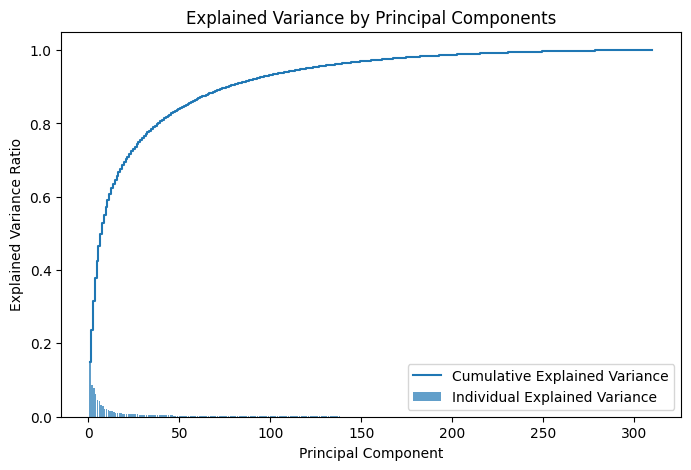

In [18]:
import matplotlib.pyplot as plt

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.show()

In [19]:
# Compute the sum of absolute loadings for each feature across all PCs
overall_feature_importance = loadings.abs().sum(axis=1).sort_values(ascending=False)

# Display top 10 most important features overall
print(overall_feature_importance.head(10))

lyric_vec_208    14.623094
lyric_vec_1      14.520947
lyric_vec_209    14.446073
lyric_vec_169    14.424547
lyric_vec_227    14.381186
lyric_vec_127    14.377815
lyric_vec_120    14.368311
lyric_vec_94     14.354542
lyric_vec_179    14.332459
lyric_vec_57     14.317756
dtype: float64


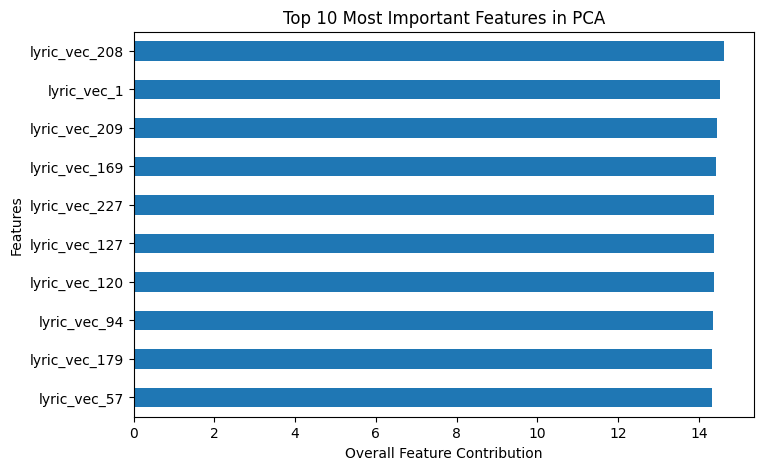

In [20]:
# Plot top 10 most important features overall
important_features = overall_feature_importance.head(10)

important_features.plot(kind='barh', figsize=(8, 5))
plt.xlabel('Overall Feature Contribution')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features in PCA')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [21]:
SEED = 100
TARGET_NAMES = ['happy', 'angry', 'sad', 'relaxed']

In [22]:
X

array([[ 0.00330033,  0.        ,  1.        , ...,  0.60934895,
        -2.2272766 ,  1.2944778 ],
       [ 0.02870813,  0.        ,  1.        , ...,  1.04982603,
        -2.07687473,  0.3946107 ],
       [ 0.05747126,  0.        ,  1.        , ...,  1.5477325 ,
        -1.8432378 ,  0.7332434 ],
       ...,
       [ 0.05747126,  0.        ,  1.        , ...,  1.5477325 ,
        -1.8432378 ,  0.7332434 ],
       [ 0.        ,  0.        ,  1.        , ..., -0.30250722,
        -1.860725  ,  0.72914004],
       [ 0.        ,  0.        ,  1.        , ...,  0.23193845,
        -1.97152162,  0.55709165]], shape=(1709, 310))

In [23]:
y

array([0, 0, 0, ..., 0, 0, 0], shape=(1709,))

In [24]:
def load_data(filepath, scenario="all"):
    df = pd.read_csv(filepath, index_col=0)

    if df.index.name == "emotion":
        df = df.reset_index()

    # Clean features using the provided function
    X, y = clean_features(df)

    # Ensure y is a 1D array of class labels (remove one-hot encoding step)
    y = np.array(y).flatten()

    # Feature selection based on scenario
    if scenario == "all":
        X_selected = X  # Use all features
    elif scenario == "lyric_embeddings":
        X_selected = X[:, 10:]  # Select only lyric embedding vectors
    elif scenario == "text_features":
        X_selected = X[:, :10]  # Select only text-based features

    # Standardize features
    scaler = StandardScaler()
    X_selected = scaler.fit_transform(X_selected)

    # Ensure balanced class representation in train/test split
    if len(set(y)) > 1:
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y, test_size=0.3, random_state=SEED, stratify=y
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y, test_size=0.3, random_state=SEED
        )

    return X_train, X_test, y_train, y_test


In [25]:
# Train and evaluate SVM
def train_svm(X_train, y_train, X_test, y_test, scenario):
    print(f"\nTraining SVM for scenario: {scenario.upper()}")

    # Define SVM model
    svm_clf = SVC(kernel="rbf", gamma=0.3, C=220)

    # Train SVM
    svm_clf.fit(X_train, y_train)

    # Predict
    y_pred = svm_clf.predict(X_test)

    # Adjust target names dynamically to match present classes
    unique_classes = np.unique(y_test)
    filtered_target_names = [TARGET_NAMES[i] for i in unique_classes]

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=filtered_target_names, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

In [26]:
# Run training for different feature scenarios
input_path = os.path.join('..', 'database', 'features', 'lyric_features.csv')

for scenario in ["all", "lyric_embeddings", "text_features"]:
    X_train, X_test, y_train, y_test = load_data(input_path, scenario)
    train_svm(X_train, y_train, X_test, y_test, scenario)

Shape of y before processing: (1709,)

Training SVM for scenario: ALL

Classification Report:
              precision    recall  f1-score   support

       happy      1.000     0.730     0.844       122
       angry      0.507     1.000     0.673       140
         sad      1.000     0.651     0.788       126
     relaxed      1.000     0.528     0.691       125

    accuracy                          0.735       513
   macro avg      0.877     0.727     0.749       513
weighted avg      0.866     0.735     0.746       513


Confusion Matrix:
[[ 89  33   0   0]
 [  0 140   0   0]
 [  0  44  82   0]
 [  0  59   0  66]]
Shape of y before processing: (1709,)

Training SVM for scenario: LYRIC_EMBEDDINGS

Classification Report:
              precision    recall  f1-score   support

       happy      1.000     0.730     0.844       122
       angry      0.507     1.000     0.673       140
         sad      1.000     0.651     0.788       126
     relaxed      1.000     0.528     0.691       1